In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler, Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import os
#assert torch.cuda.is_available()

# Problem 1
Download the CIFAR10 training and test datasets.
Transform them into tensors, normalize them as described above in the code, and create DataLoaders for each one. 
For the training set, use a batch size of 32, and for the test set, use a batch size of 1.

In [4]:
#create the data class
class CIFAR10(Dataset):

    def __init__(self, data_path= '../data', train=True):
        super(CIFAR10, self).__init__()
        self.data_path = data_path
        self.train = train
        #now load the data
        self.transform = transforms.Compose(
                              [transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.data = datasets.CIFAR10(data_path, train = train, download=True, transform=self.transform) 

    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return len(self.data)

# Download data
classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks')
train_data = CIFAR10(train=True)
valid_data = CIFAR10(train=False)
train_loader = DataLoader(train_data, batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=True)
print(len(train_data))
print(len(valid_data))


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
50000
10000


# Problem 2

Create a convolution model class convoles an image of size $3\times 32 \times 32$ into a 1D tensor that represents the $10$ classes.
The model should have at least three convolution layers, each followed by an activation function, and include at least two linear layers and one maxpool layer.
Select channels and kernel sizes so that you get at least $50,000$ parameters.

Calculate and print the number of learnable parameters in your model.

Initialize your model and move it to the device.
Run the model on a single image to make sure there are no errors.


In [5]:
class ConvolutionModel(nn.Module):
    def __init__(self):
        super(ConvolutionModel,self).__init__()
        #intialize layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1)
        #nx30x30
        self.relu = nn.ReLU()       
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        #nx28x28
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        #nx14x14
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        #nx12x12
        self.flatten = nn.Flatten()
        #1x(n*12*12)
        self.linear_1 = nn.Linear(in_features=128*12*12, out_features=1000)
        #1x1000
        self.linear_2 = nn.Linear(in_features=1000, out_features=10)
        #1x10
    def forward(self,x):
        output = self.relu(self.conv2(self.relu(self.conv1(x))))
        output = self.relu(self.conv3(self.maxpool(output)))
        return self.linear_2(self.linear_1(self.flatten(output)))

In [6]:
def count_parameters(model): 
  return sum(p.numel() for p in model.parameters())
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

# Problem 3

Train the model by looping through the training data. Inside the loop, you should
1. Zero out the gradients.
2. Run the model on the inputs.
3. Calculate the loss on the model output and the actual label.
4. Backpropogate the error.
5. Optimize.

Run the loop for 10 epochs. At the end of each epoch, calculate the mean loss of the
training data for that epoch. Then calculate the accuracy of the model on the test data. Since
the model is no longer training, it needs to be set to evaluation mode using model.eval().
To resume training at the beginning of the next epoch, set the model to training mode using
model.train().

You should have around $50\%$ accuracy at the end of $10$ epochs.

Plot the epochs v. mean training loss each epoch and the epochs v. accuracy.


In [7]:
#intialize constants optimizer and objective function
device = torch.device('cuda:0')
num_epochs = 10
lr=1e-4
model = ConvolutionModel()
model = model.to(device)
val_mean_acs = list()
val_mean_loss = list()
train_mean_acs = list()
train_mean_loss = list()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# Progress bar
pbar = tqdm(total=len(train_loader) * num_epochs)
for epoch in range(num_epochs):
    train_losses = list()
    train_acs = list()
    model.train()
    for x, y_truth in train_loader:
        #get the data
        x, y_truth = x.to(device), y_truth.to(device)
        #zero the gradient
        optimizer.zero_grad()
        #get the prediction
        y_hat = model(x)
        #get the loss
        train_loss = objective(y_hat, y_truth)
        train_acc = accuracy(y_hat, y_truth)
        #backward propagate loss
        train_loss.backward()
        #take step with the optimizer
        optimizer.step()
        #append losses and accuracies to list
        train_losses.append(train_loss.item())
        train_acs.append(train_acc.item())
        #update the status bar
        pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
        pbar.update(1)    
    #average the losses
    train_mean_loss.append(np.mean(train_losses))
    #average the accuracies
    train_mean_acs.append(np.mean(train_acs))
    model.eval()
    #do the validation step
    val_losses = list()
    val_accs = list()
    for x, y_truth in valid_loader:
        x, y_truth = x.to(device), y_truth.to(device)
        y_hat = model(x)
        val_losses.append(objective(y_hat, y_truth).item())
        val_accs.append(accuracy(y_hat, y_truth).item())
    #now get the means
    val_mean_acs.append(np.mean(val_accs))
    val_mean_loss.append(np.mean(val_losses))
pbar.close()

train loss:0.2296, train accuracy:0.8750.: 100%|██████████| 15630/15630 [07:58<00:00, 32.67it/s]


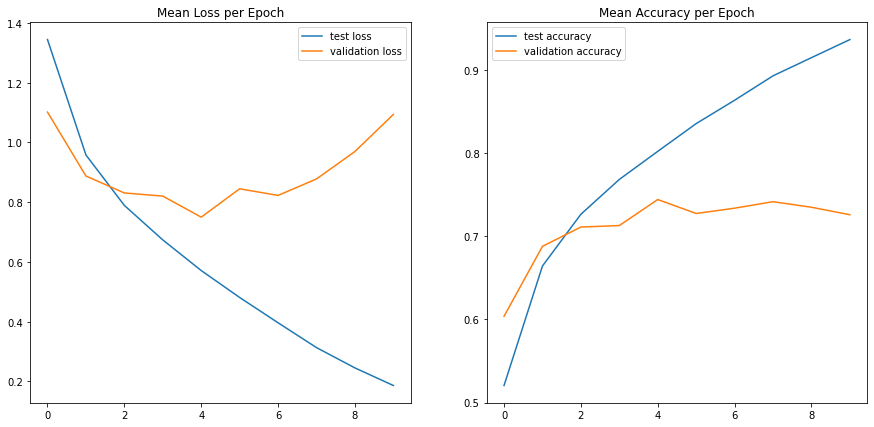

In [8]:
#plot the results
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].plot(train_mean_loss,label='test loss')
ax[0].plot(val_mean_loss,label='validation loss')
ax[0].legend()
ax[0].set_title("Mean Loss per Epoch")
ax[1].plot(train_mean_acs,label='test accuracy')
ax[1].plot(val_mean_acs,label='validation accuracy')
ax[1].legend()
ax[1].set_title("Mean Accuracy per Epoch")
plt.show()

# Problem 4

Write a function that loops through the test data, modifying the images as described.

Run your function for each epsilon in $[0,.05,.1,.15,.2,.25,.3]$, and plot epsilon v. accuracy.

Display the perturbed version of the first image in the test data for each epsilon.

In [11]:
def check_accuracy(y_truth, y_hat):
    pred = torch.argmax(y_hat, dim=1)
    acc = pred == y_truth
    return acc
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)

In [20]:
def adversarial_attack(model, data_loader, epsilon):
    accuracies = list()
    counter = 0
    for x, y_truth in data_loader:
        #get the data
        model.train()
        x, y_truth = x.to(device), y_truth.to(device)
        x.requires_grad = True
        #zero the gradient
        optimizer.zero_grad()
        #get the prediction
        y_hat = model(x)
        train_loss = objective(y_hat, y_truth)
        if (check_accuracy(y_truth,y_hat).item() is not True):
            accuracies.append(0)
            continue
        #backward propagate loss
        train_loss.backward()
        #take step with the optimizer
        optimizer.step()
        #get the the gradient
        data_grad = x.grad.data
        perturbed_data = fgsm_attack(x.data, epsilon, data_grad)
        model.eval()
        y = model(perturbed_data)
        if (counter == 0):
          img = perturbed_data.squeeze().detach().cpu().numpy()
          img = img/2 + 0.5
          plt.imshow(np.transpose(img, (1,2,0)))
          plt.show()
        #compute the accuracy of the prediction
        if (check_accuracy(y_truth,y).item() is True):
            accuracies.append(1)
        else:
            accuracies.append(0)
        counter += 1

    return np.sum(accuracies)/len_valid

Files already downloaded and verified
Epsilon: 0


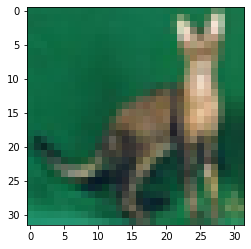

Epsilon: 0.05


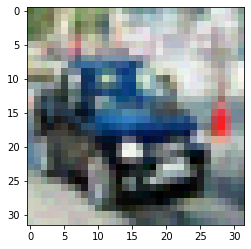

Epsilon: 0.1


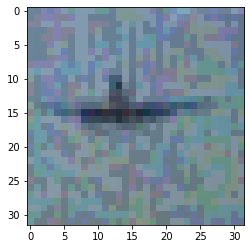

Epsilon: 0.15


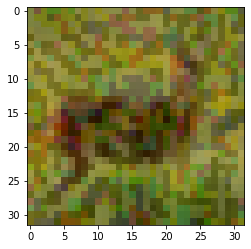

Epsilon: 0.2


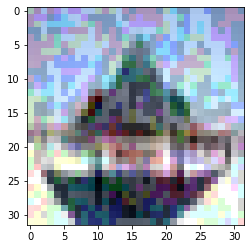

Epsilon: 0.25


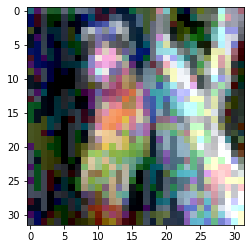

Epsilon: 0.3


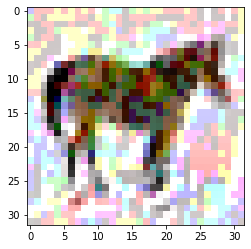

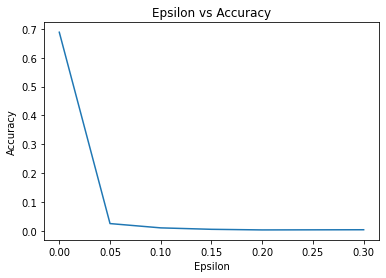

In [21]:
valid_data = CIFAR10(train=False)
eps_list = [0,0.05,0.1,0.15,0.2,0.25,0.3]
acc_list = []
#loop through the epsilon values
for epsilon in eps_list:
    print("Epsilon: {}".format(epsilon))
    model_attack = copy.deepcopy(model)
    data_loader = DataLoader(valid_data, batch_size=1, shuffle=True)
    len_valid = len(data_loader)
    acc_list.append(adversarial_attack(model_attack, data_loader, epsilon))
plt.plot(eps_list,acc_list)
plt.title("Epsilon vs Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()